## testing several models for both the SeaFlow and Zinser (updated) datasets
 * modified from 2020-04-24 notebook
 * this is to test exponential formulations for growth and respiration as well as the effect of light-dependent division
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

### load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for k in datafiles:
    data_gridded[k] = {}
    with nc4.Dataset(datafiles[k]) as nc:
        for var in nc.variables:
            data_gridded[k][var] = nc.variables[var][:]
    desc[k] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[k])

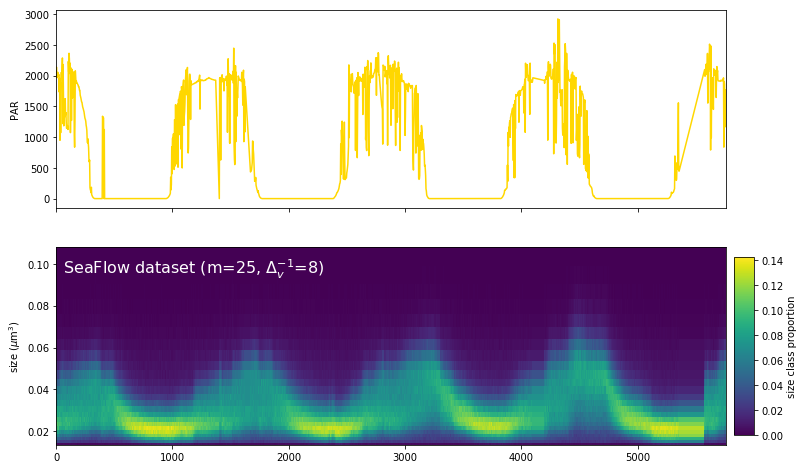

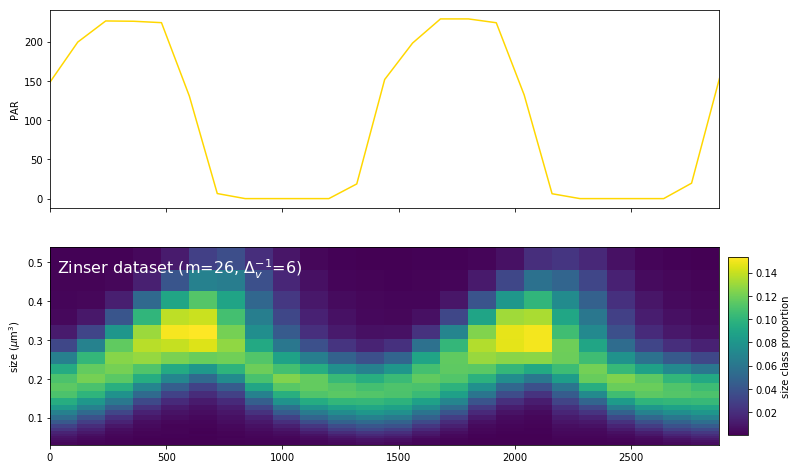

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

for i,k in enumerate(data_gridded):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    ax.plot(data_gridded[k]['time'], data_gridded[k]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    v_min = data_gridded[k]['v_min']
    delta_v = 1.0/data_gridded[k]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[k]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[k]['time'],v,data_gridded[k]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[k], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
axs[-1].set_xlabel=('time (minutes)')
None

### process data and plot it

In [3]:
# prepare data for Stan model

data = {}
mcmcs = {}
models = {}

In [4]:
for k in data_gridded:
    dt = 20 # in units of minutes
    
    data[k] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[k][v] = data_gridded[k][v]

    if 'seaflow' in k:
        limit_days = 1
        
        # new: average SeaFlow data in hourly bins
        binsize = 60 # in minutes
        numbins = int(np.ceil(data_gridded[k]['time'][-1]/binsize))
        
        data[k]['obs'] = np.full((data[k]['m'],numbins), fill_value=np.nan)
        data[k]['t_obs'] = np.full(numbins, fill_value=np.nan)
        
        i = 0
        for ibin in range(numbins):
            binind = np.logical_and(data_gridded[k]['time'] >= ibin*binsize,
                                    data_gridded[k]['time'] < (ibin+1)*binsize)
            if np.any(binind):
                # TODO we may want to make this a sum when dealing with counts
                data[k]['obs'][:,i] = np.mean(data_gridded[k]['w_obs'][:,binind], axis=1)
                data[k]['t_obs'][i] = (ibin+0.5) * binsize
                i += 1
        
        data[k]['obs'] = data[k]['obs'][:,:i]
        data[k]['t_obs'] = data[k]['t_obs'][:i]
        
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[k]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[k]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[k]['obs'] = data_gridded[k]['w_obs']
        data[k]['t_obs'] = data_gridded[k]['time']
        par = data_gridded[k]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[k]['t_obs'] < limit_minutes
        data[k]['t_obs'] = data[k]['t_obs'][ind_obs]
        data[k]['obs'] = data[k]['obs'][:,ind_obs]
        
        data[k]['nt'] = int(limit_minutes//data[k]['dt'])

    data[k]['nt_obs'] = data[k]['t_obs'].size
    
    # load cross-validation testing indices and add them to data
    data[k]['i_test'] = np.loadtxt(itestfiles[k]).astype(int)
    # remove last index, so that dimensions agree
    data[k]['i_test'] = data[k]['i_test'][:-1]
    
    # add light data
    t = np.arange(data[k]['nt'])*data[k]['dt']
    data[k]['E'] = np.interp(t, xp=data_gridded[k]['time'], fp=par)
    
    # for now, add pseudo-count data
    data[k]['obs_count'] = (1000*data[k]['obs']).astype(int)
    
    # consistency check
    if len(data[k]['i_test']) != data[k]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(k,data[k]['nt_obs'],len(data[k]['i_test'])))

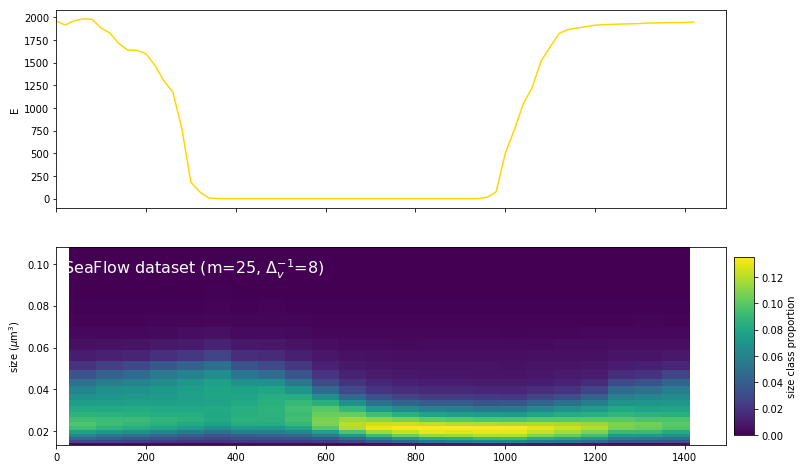

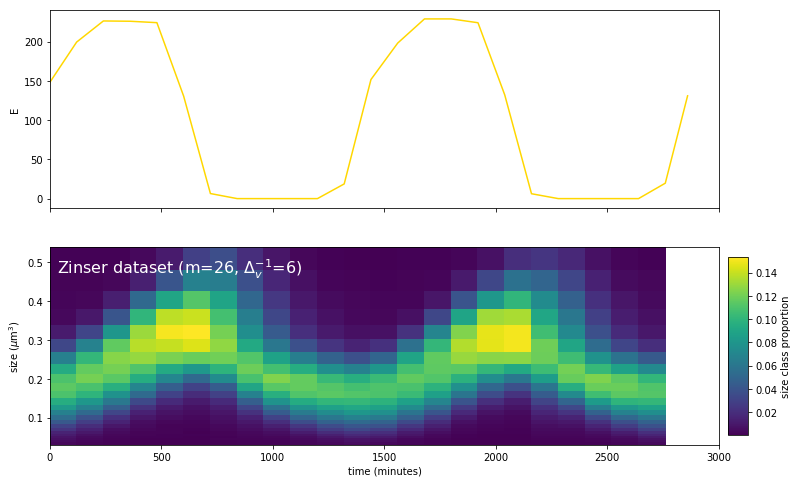

In [5]:
for i,k in enumerate(data):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    t = np.arange(data[k]['nt'])*data[k]['dt']
    ax.plot(t, data[k]['E'], color='gold')
    ax.set(ylabel='E')

    v_min = data[k]['v_min']
    delta_v = 1.0/data[k]['delta_v_inv']
    v = v_min * 2**(np.arange(data[k]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data[k]['t_obs'],v,data[k]['obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[k], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')

None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [6]:
import pystan
refit_all = False
refit_required = {}

modelfiles = {
    #'monodelta_respv2_mn':'stancode/matrixmodel_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
    #'monodelta_respv2_mn_lightsig':'stancode/matrixmodel_estinilnorm_monodelta-lightsig_respv2_normparam_trackgrowth_xval.stan',
    'monodelta_respiv6_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv6_normparam_trackgrowth_xval.stan',   
    #'monodelta_respiv6_mn_lightsig':'stancode/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv6_normparam_trackgrowth_xval.stan',   
    'monodelta_respiv7_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv7_normparam_trackgrowth_xval.stan',   
    #'monodelta_respiv7_mn_lightsig':'stancode/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv7_normparam_trackgrowth_xval.stan',   
}
desc_model = {
    'monodelta_respv2_mn':'OLD: respiration v2 (no size-dep), monotone deltas (exp AR1)',
    'monodelta_respv2_mn_lightsig':'OLD: respiration v2 (no size-dep), monotone deltas (exp AR1), light-dep div',
    'monodelta_respiv6_mn':'size-dep growth/resp v6, monotone deltas (exp AR1)',
    'monodelta_respiv6_mn_lightsig':'size-dep growth/resp v6, monotone deltas (exp AR1), light-dep div',
    'monodelta_respiv7_mn':'size-dep growth/resp v7, monotone deltas (exp AR1)',
    'monodelta_respiv7_mn_lightsig':'size-dep growth/resp v7, monotone deltas (exp AR1), light-dep div',
}

for name in modelfiles:
    with open(modelfiles[name]) as f: 
        stan_code = f.read()
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(file=modelfiles[name], model_name=name, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respiv6_mn NOW.


monodelta_respiv6_mn: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respiv7_mn NOW.


monodelta_respiv7_mn: compiling


In [7]:
def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

try_again = False

# run a bunch of experiments -- this may take a while
for name in models:
    for k in data:
        if name in mcmcs:
            if k in mcmcs[name] and not refit_all and not refit_required[name]:
                print('{} ({})'.format(name, desc_model[name])) 
                print('\n'.join(x for x in mcmcs[name][k].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[name][k])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(name,rhat_max))
                else:
                    continue
        else:
            mcmcs[name] = {}
        for itry in range(3):
            mcmcs[name][k] = models[name].sampling(data=data[k], iter=2000)
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[name][k])
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
        print('{} ({})'.format(name, desc_model[name])) 
        print('\n'.join(x for x in mcmcs[name][k].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))

monodelta_respiv6_mn (size-dep growth/resp v6, monotone deltas (exp AR1))
Inference for Stan model: monodelta_respiv6_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda          0.32  4.1e-3     0.1    0.18    0.25    0.31    0.37    0.54    538    1.0
gamma_max             1.26  1.7e-3    0.05    1.16    1.22    1.26    1.29    1.37    986    1.0
xi                    0.03  3.0e-3     0.1   -0.17   -0.04    0.03     0.1    0.22   1209    1.0
xir                 4.2e-4  3.0e-3     0.1   -0.19   -0.07  5.3e-5    0.06     0.2   1096    1.0
respiration           0.02  6.0e-4    0.02  1.4e-3    0.01    0.02    0.04    0.06    780   1.01
E_star                8.97    0.95   24.13    0.11     0.8    1.63    3.41   73.68    643   1.01
divrate               0.74  1.1e-3    0.03    0.68    0.72    0.74    0.76     0.

monodelta_respiv6_mn: in try 1/3 found Rhat=1010.798, trying again


monodelta_respiv6_mn: in try 2/3 found Rhat=1006.851, trying again


monodelta_respiv6_mn: in try 3/3 found Rhat=5906.386, trying again
monodelta_respiv6_mn (size-dep growth/resp v6, monotone deltas (exp AR1))
Inference for Stan model: monodelta_respiv6_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
delta_lambda          2.75    0.41   0.82    1.79    1.79    2.73   3.32   4.54      4   1.41
gamma_max             7.98    2.87   4.07    5.28    5.52     5.7  11.29  15.03      2  22.88
xi                   -0.94    0.39   0.55    -1.4   -1.29   -1.23  -0.45 7.1e-3      2   8.99
xir                  -0.37    0.88   1.25   -2.53   -1.35    0.31   0.38   0.49      2  18.88
respiration           1.38    0.52   0.74    0.11    0.77    1.78   1.83   1.93      2  13.43
E_star              113.15   38.32  55.02   62.05   75.91   86.36 176.98 206.88      2   5.58
divrate               1.37    1.01 

monodelta_respiv7_mn (size-dep growth/resp v7, monotone deltas (exp AR1))
Inference for Stan model: monodelta_respiv7_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda          0.31  3.5e-3    0.09    0.17    0.25     0.3    0.36    0.51    644   1.01
gamma_max             1.31  2.2e-3    0.06    1.19    1.27    1.31    1.34    1.41    643   1.01
xi                    0.03  3.0e-3     0.1   -0.16   -0.04    0.03     0.1    0.23   1062    1.0
xir                 2.9e-3  3.9e-3     0.1    -0.2   -0.07  4.9e-4    0.07     0.2    694    1.0
respiration           0.11  8.7e-4    0.02    0.07     0.1    0.11    0.12    0.15    571    1.0
E_star                 9.3    0.88   22.66    0.05     0.7    1.56    4.16   72.32    669    1.0
divrate               0.68  1.2e-3    0.03    0.62    0.66    0.68     0.7    0.7

monodelta_respiv7_mn: in try 1/3 found Rhat=10.937, trying again


monodelta_respiv7_mn: in try 2/3 found Rhat=3516.432, trying again


monodelta_respiv7_mn: in try 3/3 found Rhat=1293.660, trying again
monodelta_respiv7_mn (size-dep growth/resp v7, monotone deltas (exp AR1))
Inference for Stan model: monodelta_respiv7_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.97     0.8    1.18    0.17     0.5    2.2   3.26   3.27      2   3.39
gamma_max           28.44   18.61   26.32    6.91    7.51  18.95  51.59   72.0      2  78.48
xi                  -0.67    0.46    0.65   -1.48   -1.32  -0.54  -0.01 1.4e-4      2  10.06
xir                  0.31    2.84    4.02   -5.52   -2.97   0.45   3.58   5.85      2  63.82
respiration          1.16    0.44    0.62    0.17    0.59   1.26   1.69   1.83      2  11.09
E_star             990.86  944.66  1336.3   89.55  113.63 353.65 2004.3 3297.8      2  96.12
divrate              1.96    1.03    1.46 

## Plot the results

In [35]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

maxrhats = {name:{k:get_max_rhat(mcmcs[name][k]) for k in data} for name in mcmcs}        

{'monodelta_respiv6_mn': {'seaflow': 1.0148407789318767, 'zinser': 5906.386128528807}, 'monodelta_respiv7_mn': {'seaflow': 1.011753629520985, 'zinser': 1293.6596559925363}}


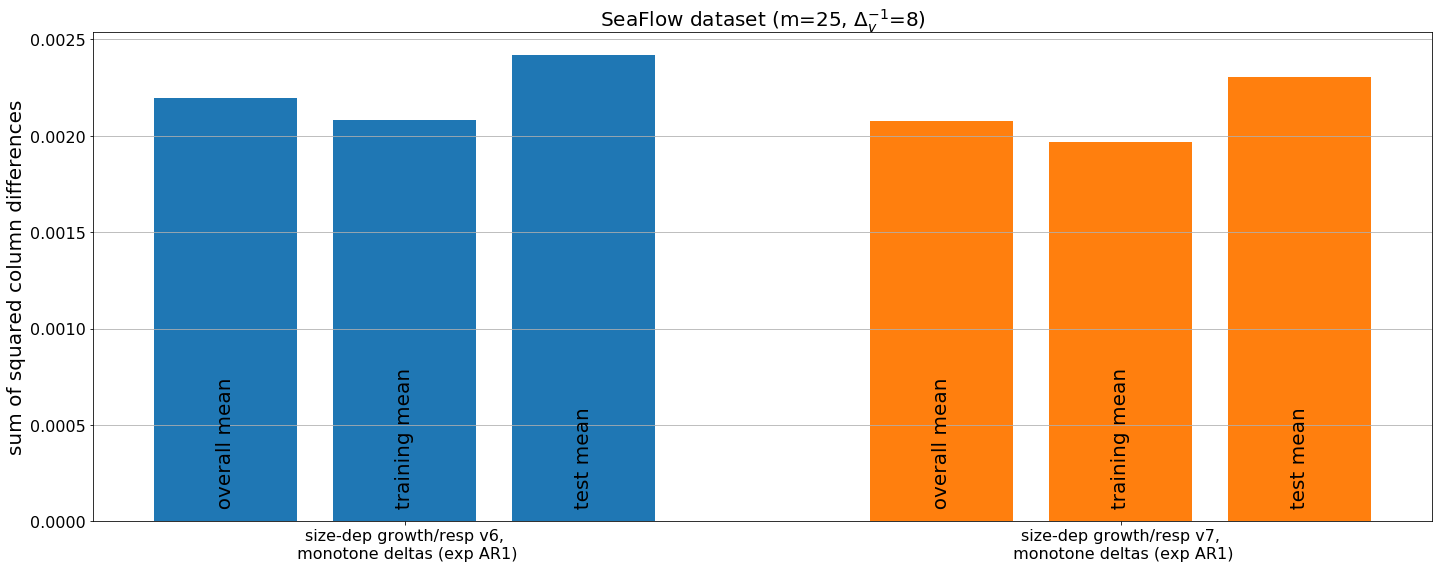

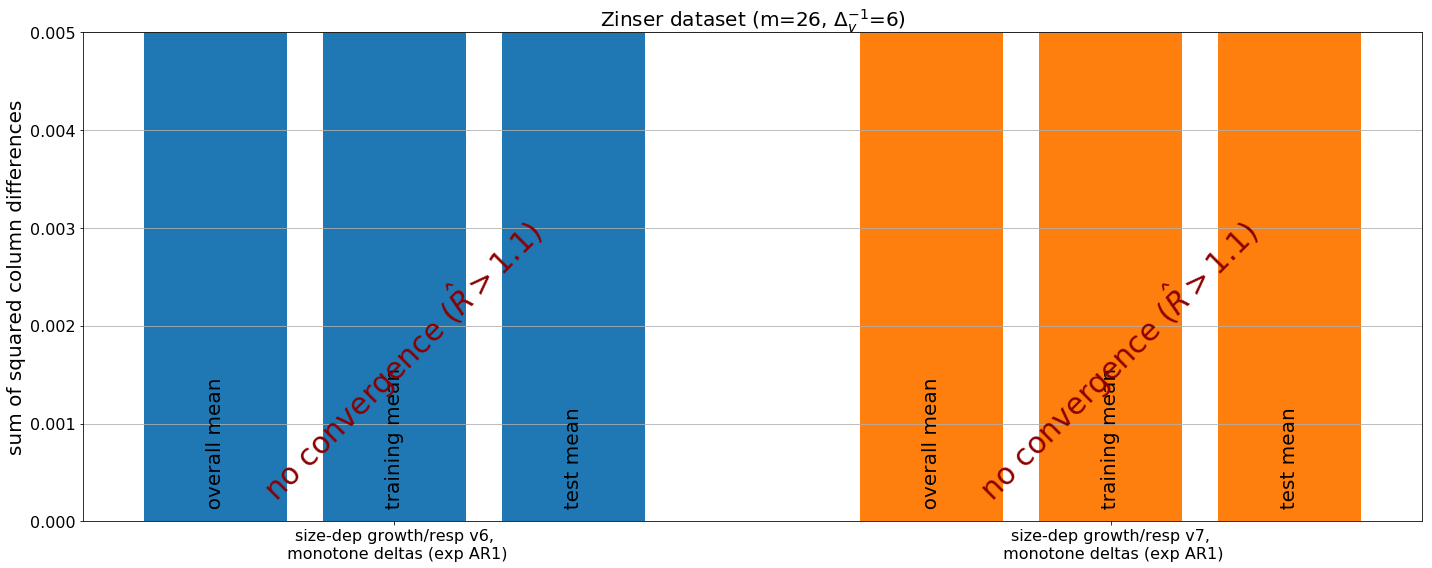

In [42]:
height = np.zeros(3)
for k in data:
    obs = data[k]['obs']
    
    fig, ax = plt.subplots(figsize=(24,9))
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[name][k]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[name],e)
        
        height[0] = np.mean(e)
        height[1] = np.mean(e[data[k]['i_test'] == 0])
        height[2] = np.mean(e[data[k]['i_test'] == 1])
        
        x = 4*i+np.arange(3)
        ax.bar(x=x, height=height)
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=20)
        if maxrhats[name][k] > 1.1:
            ax.text(x[1], 0, '  no convergence ($\\hat{R}>1.1$)', rotation=45, ha='center', va='bottom', size=30, color='darkred')
        xticks.append(x[1])
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title(desc[k], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

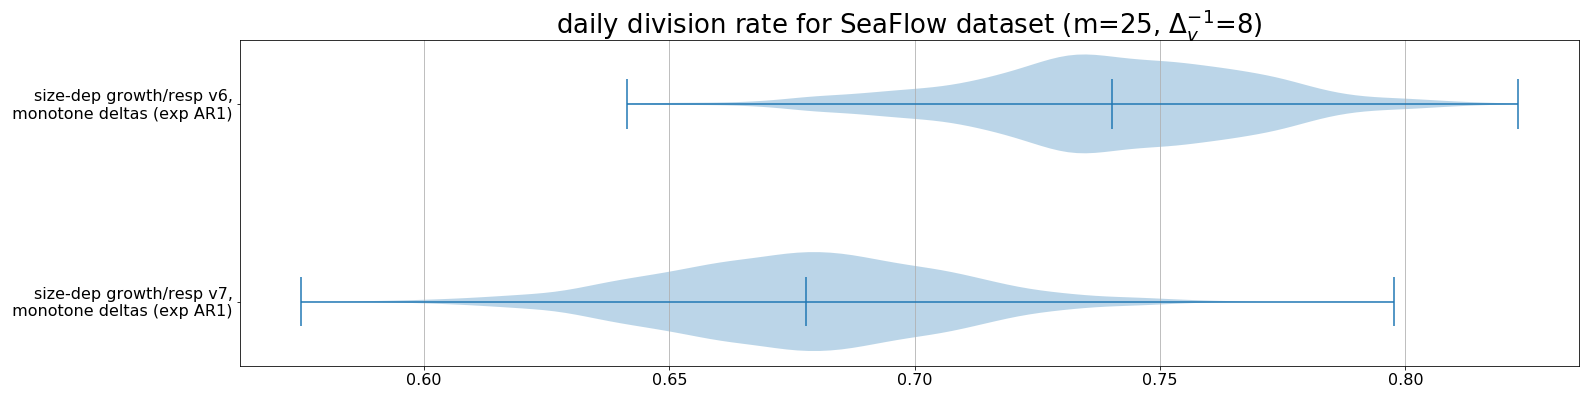

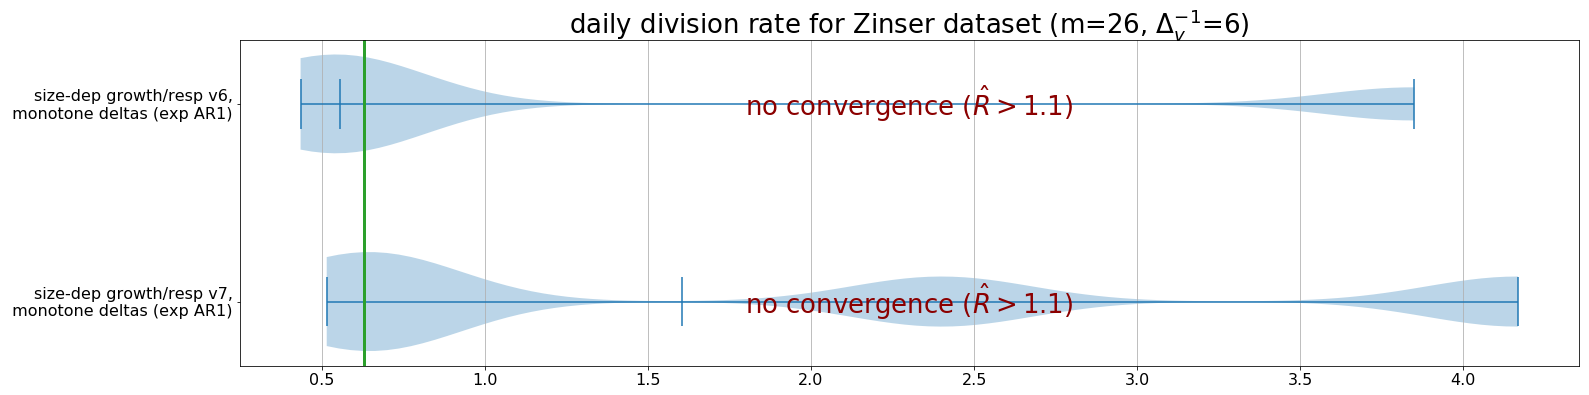

In [50]:
for k in data:
    num_mcmcs = len(mcmcs)
    fig, ax = plt.subplots(figsize=(24,3*num_mcmcs))
    ax.set_title('daily division rate for '+desc[k])
    ax.violinplot([mcmcs[name][k]['divrate'] for name in mcmcs], showmedians=True, vert=False)
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.set(yticks=np.arange(1,num_mcmcs+1), yticklabels=[desc_model[name].replace(',',',\n') for name in mcmcs])
    if 'zinser' in k:
        ax.axvline(0.63, color='tab:green', lw=3)
    for i,name in enumerate(mcmcs):
        if maxrhats[name][k] > 1.1:
            ax.text(0.5, i+1, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.get_yaxis_transform(), ha='center', va='center')

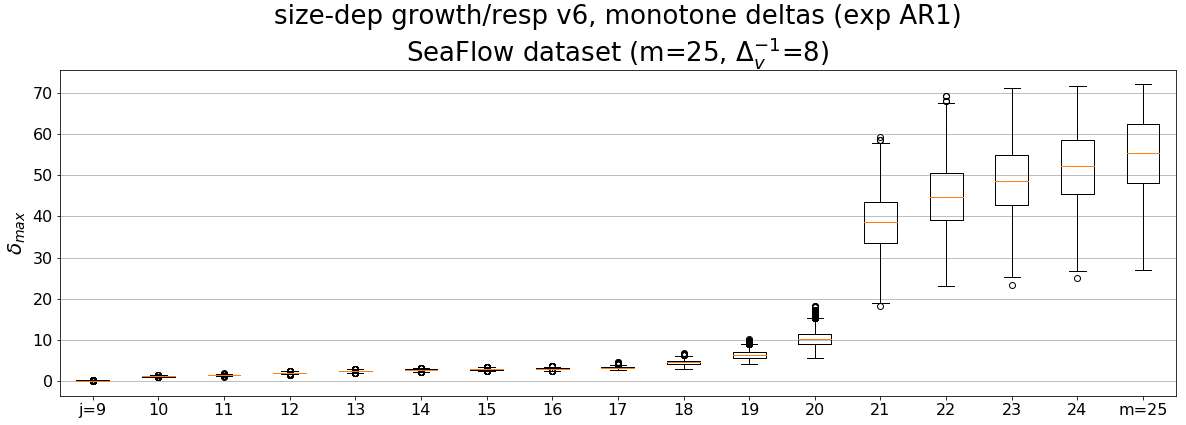

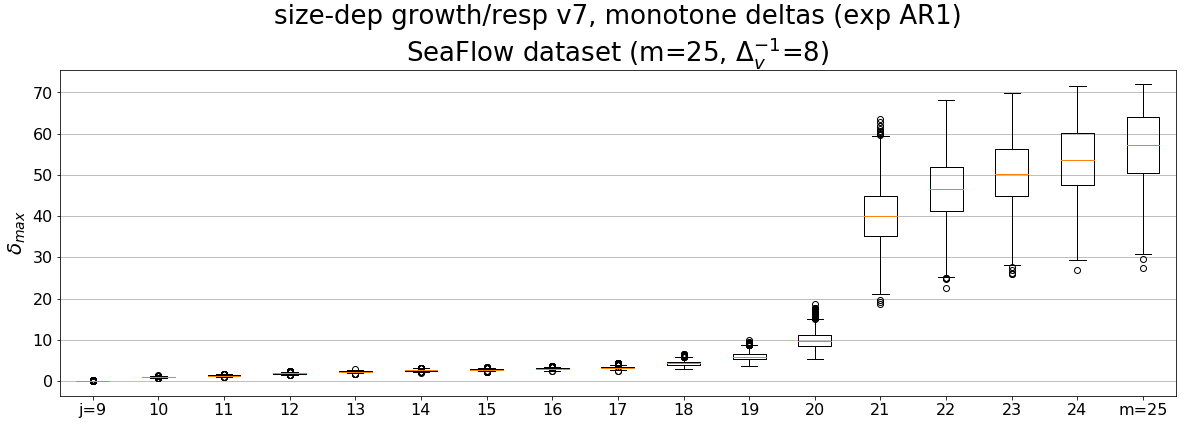

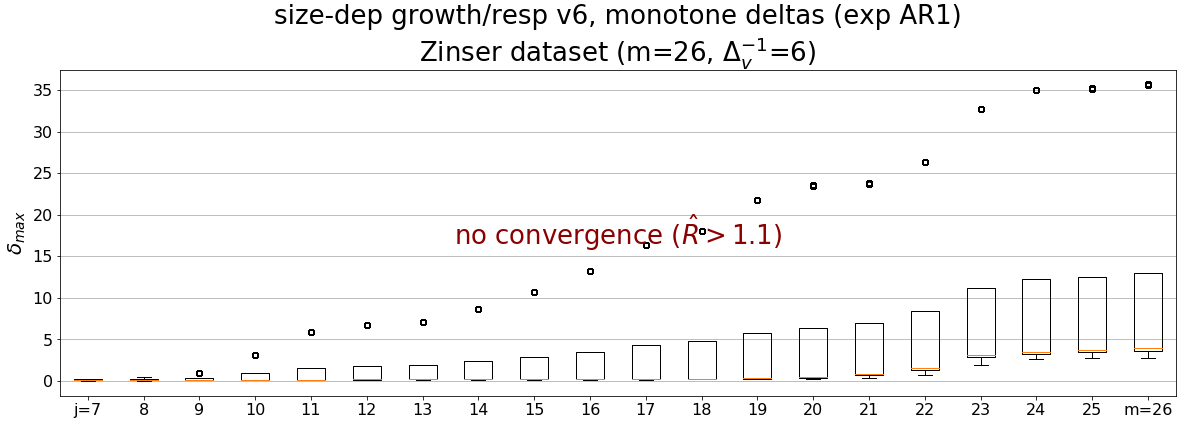

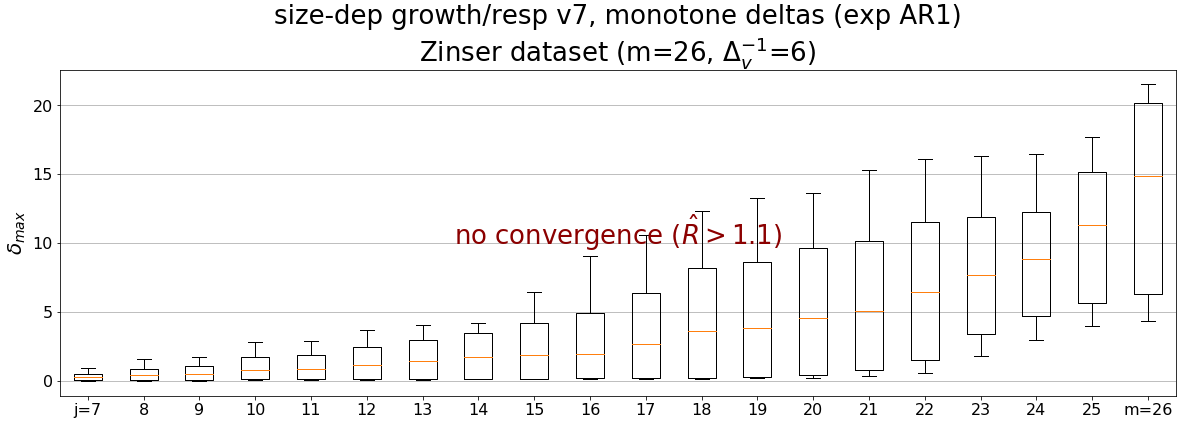

In [45]:
for k in data:
    for name,mcmc in mcmcs.items():
        j = data_gridded[k]['delta_v_inv'] + 1
        m = data_gridded[k]['m']

        fig, ax = plt.subplots(figsize=(20,6))
        ax.set_title(desc_model[name] + '\n' + desc[k])
        ax.boxplot(mcmc[k]['delta_max'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        ax.set_ylabel('$\\delta_{max}$')
        
        if maxrhats[name][k] > 1.1:
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
        None

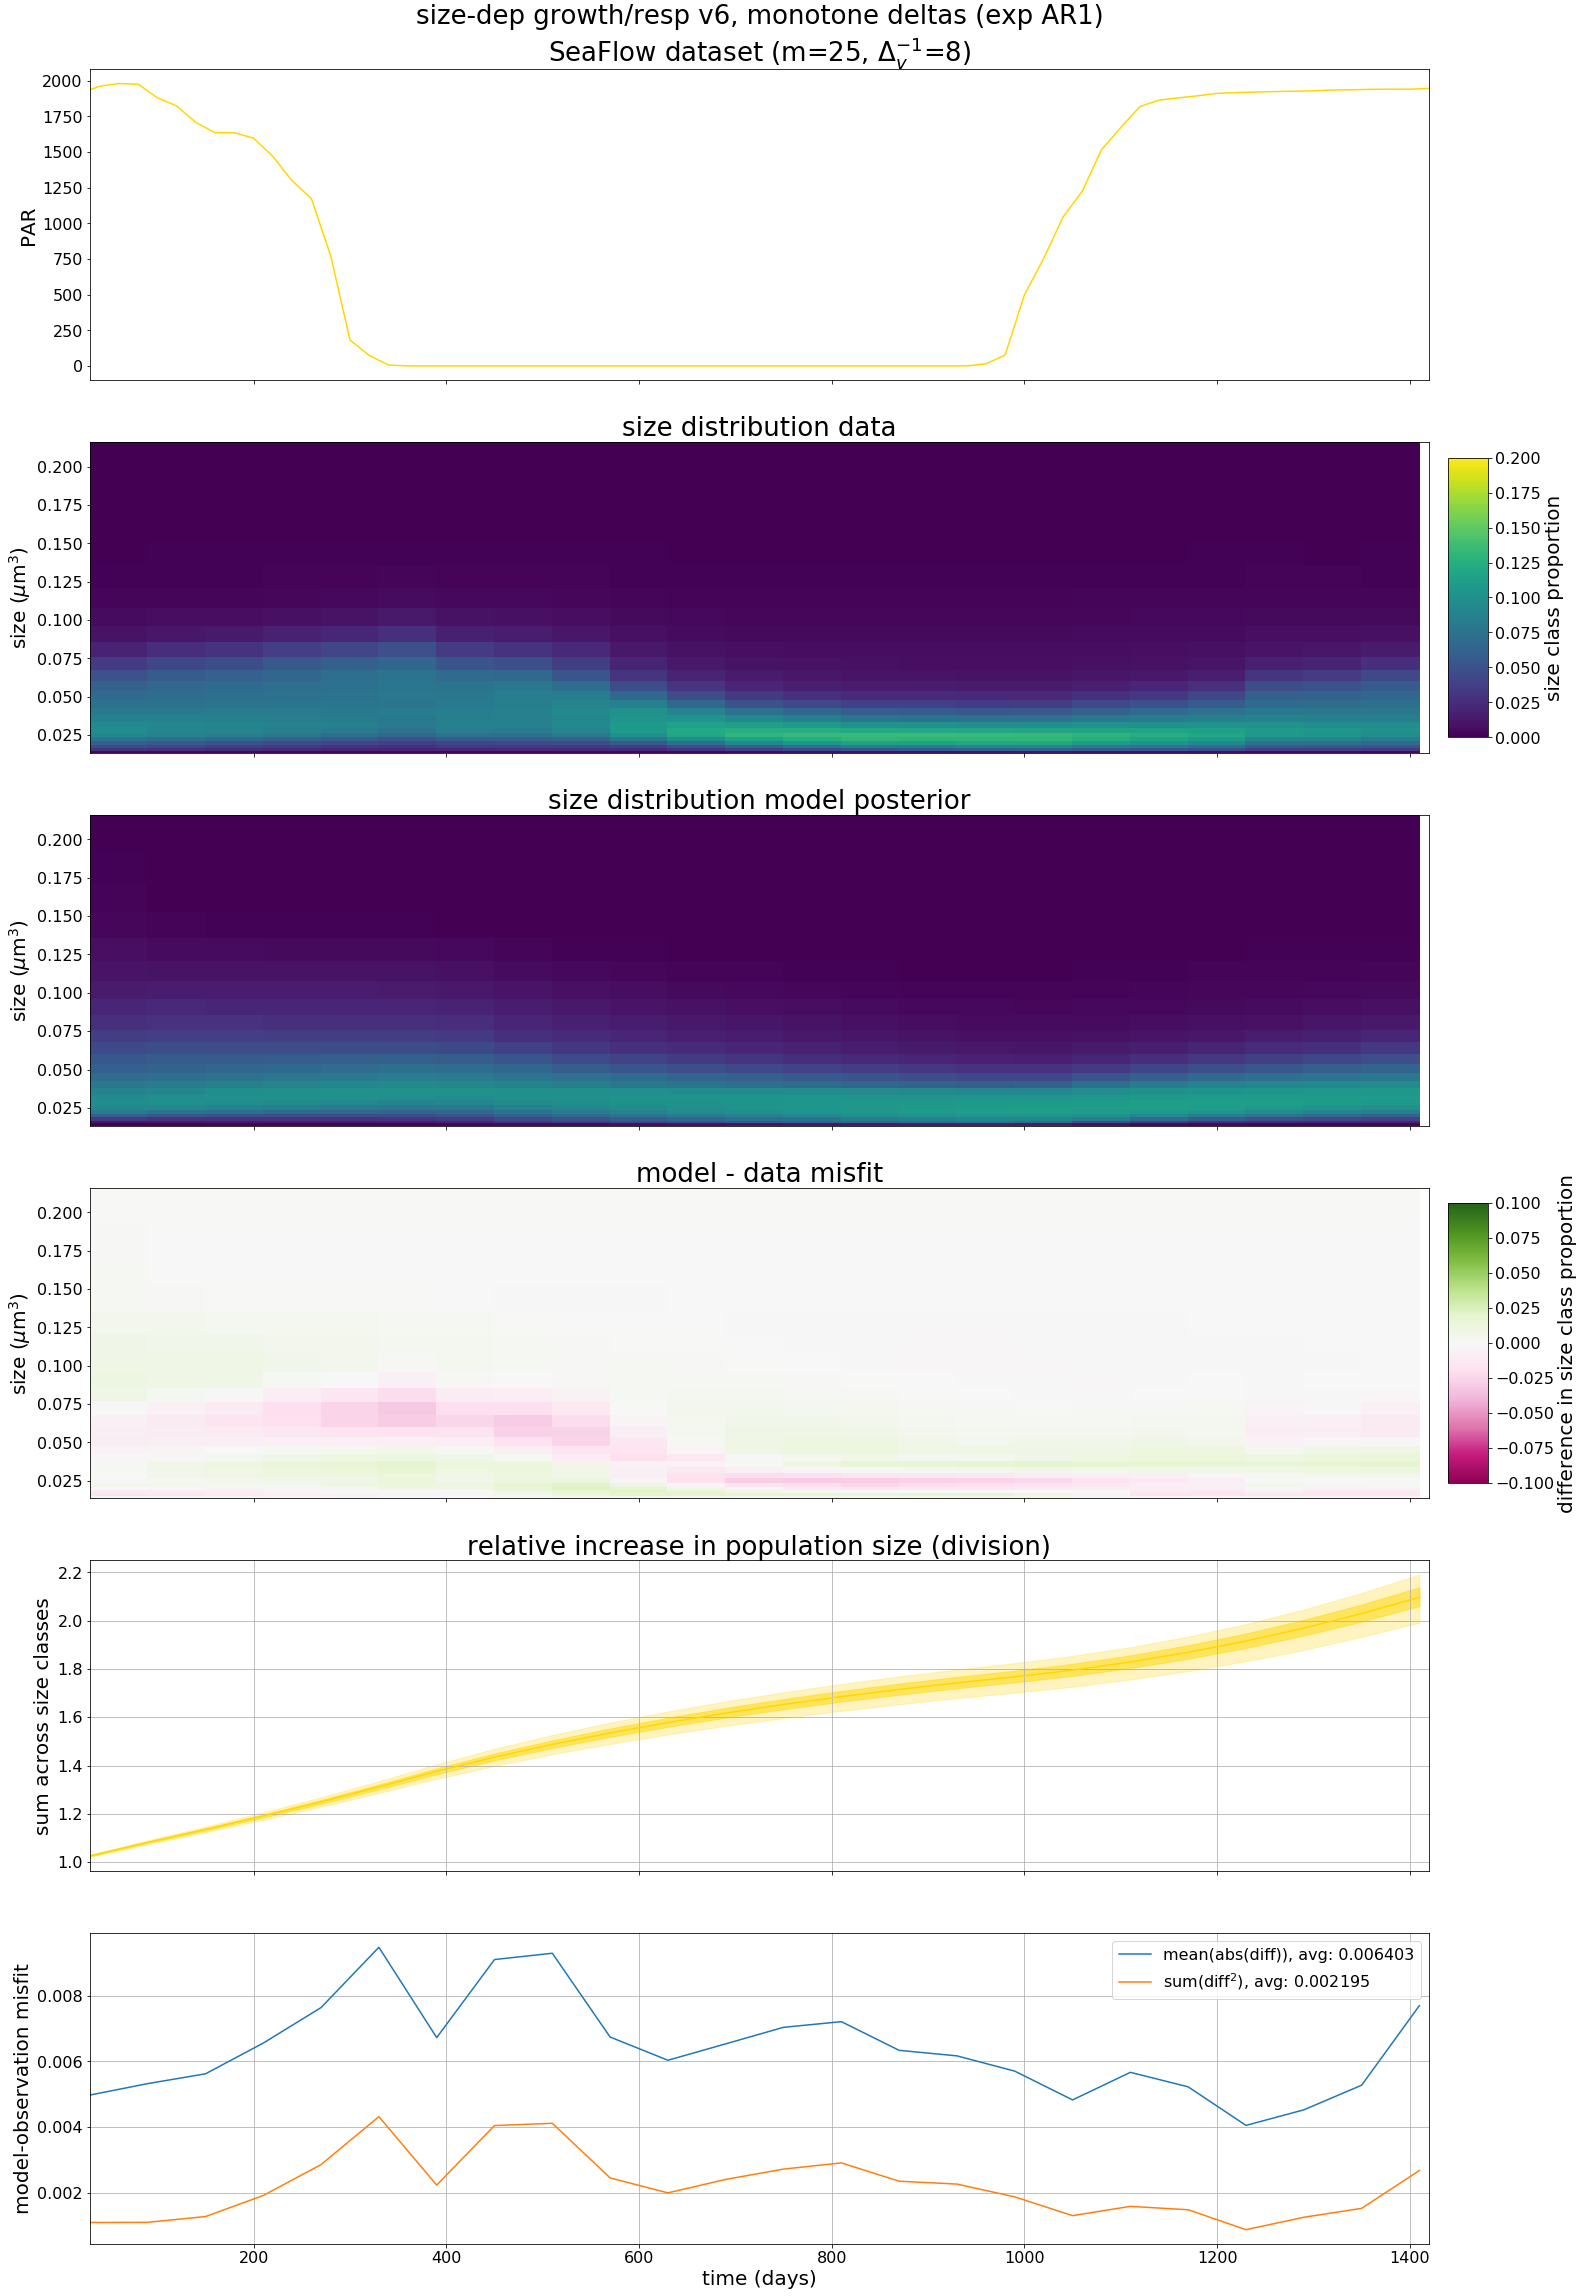

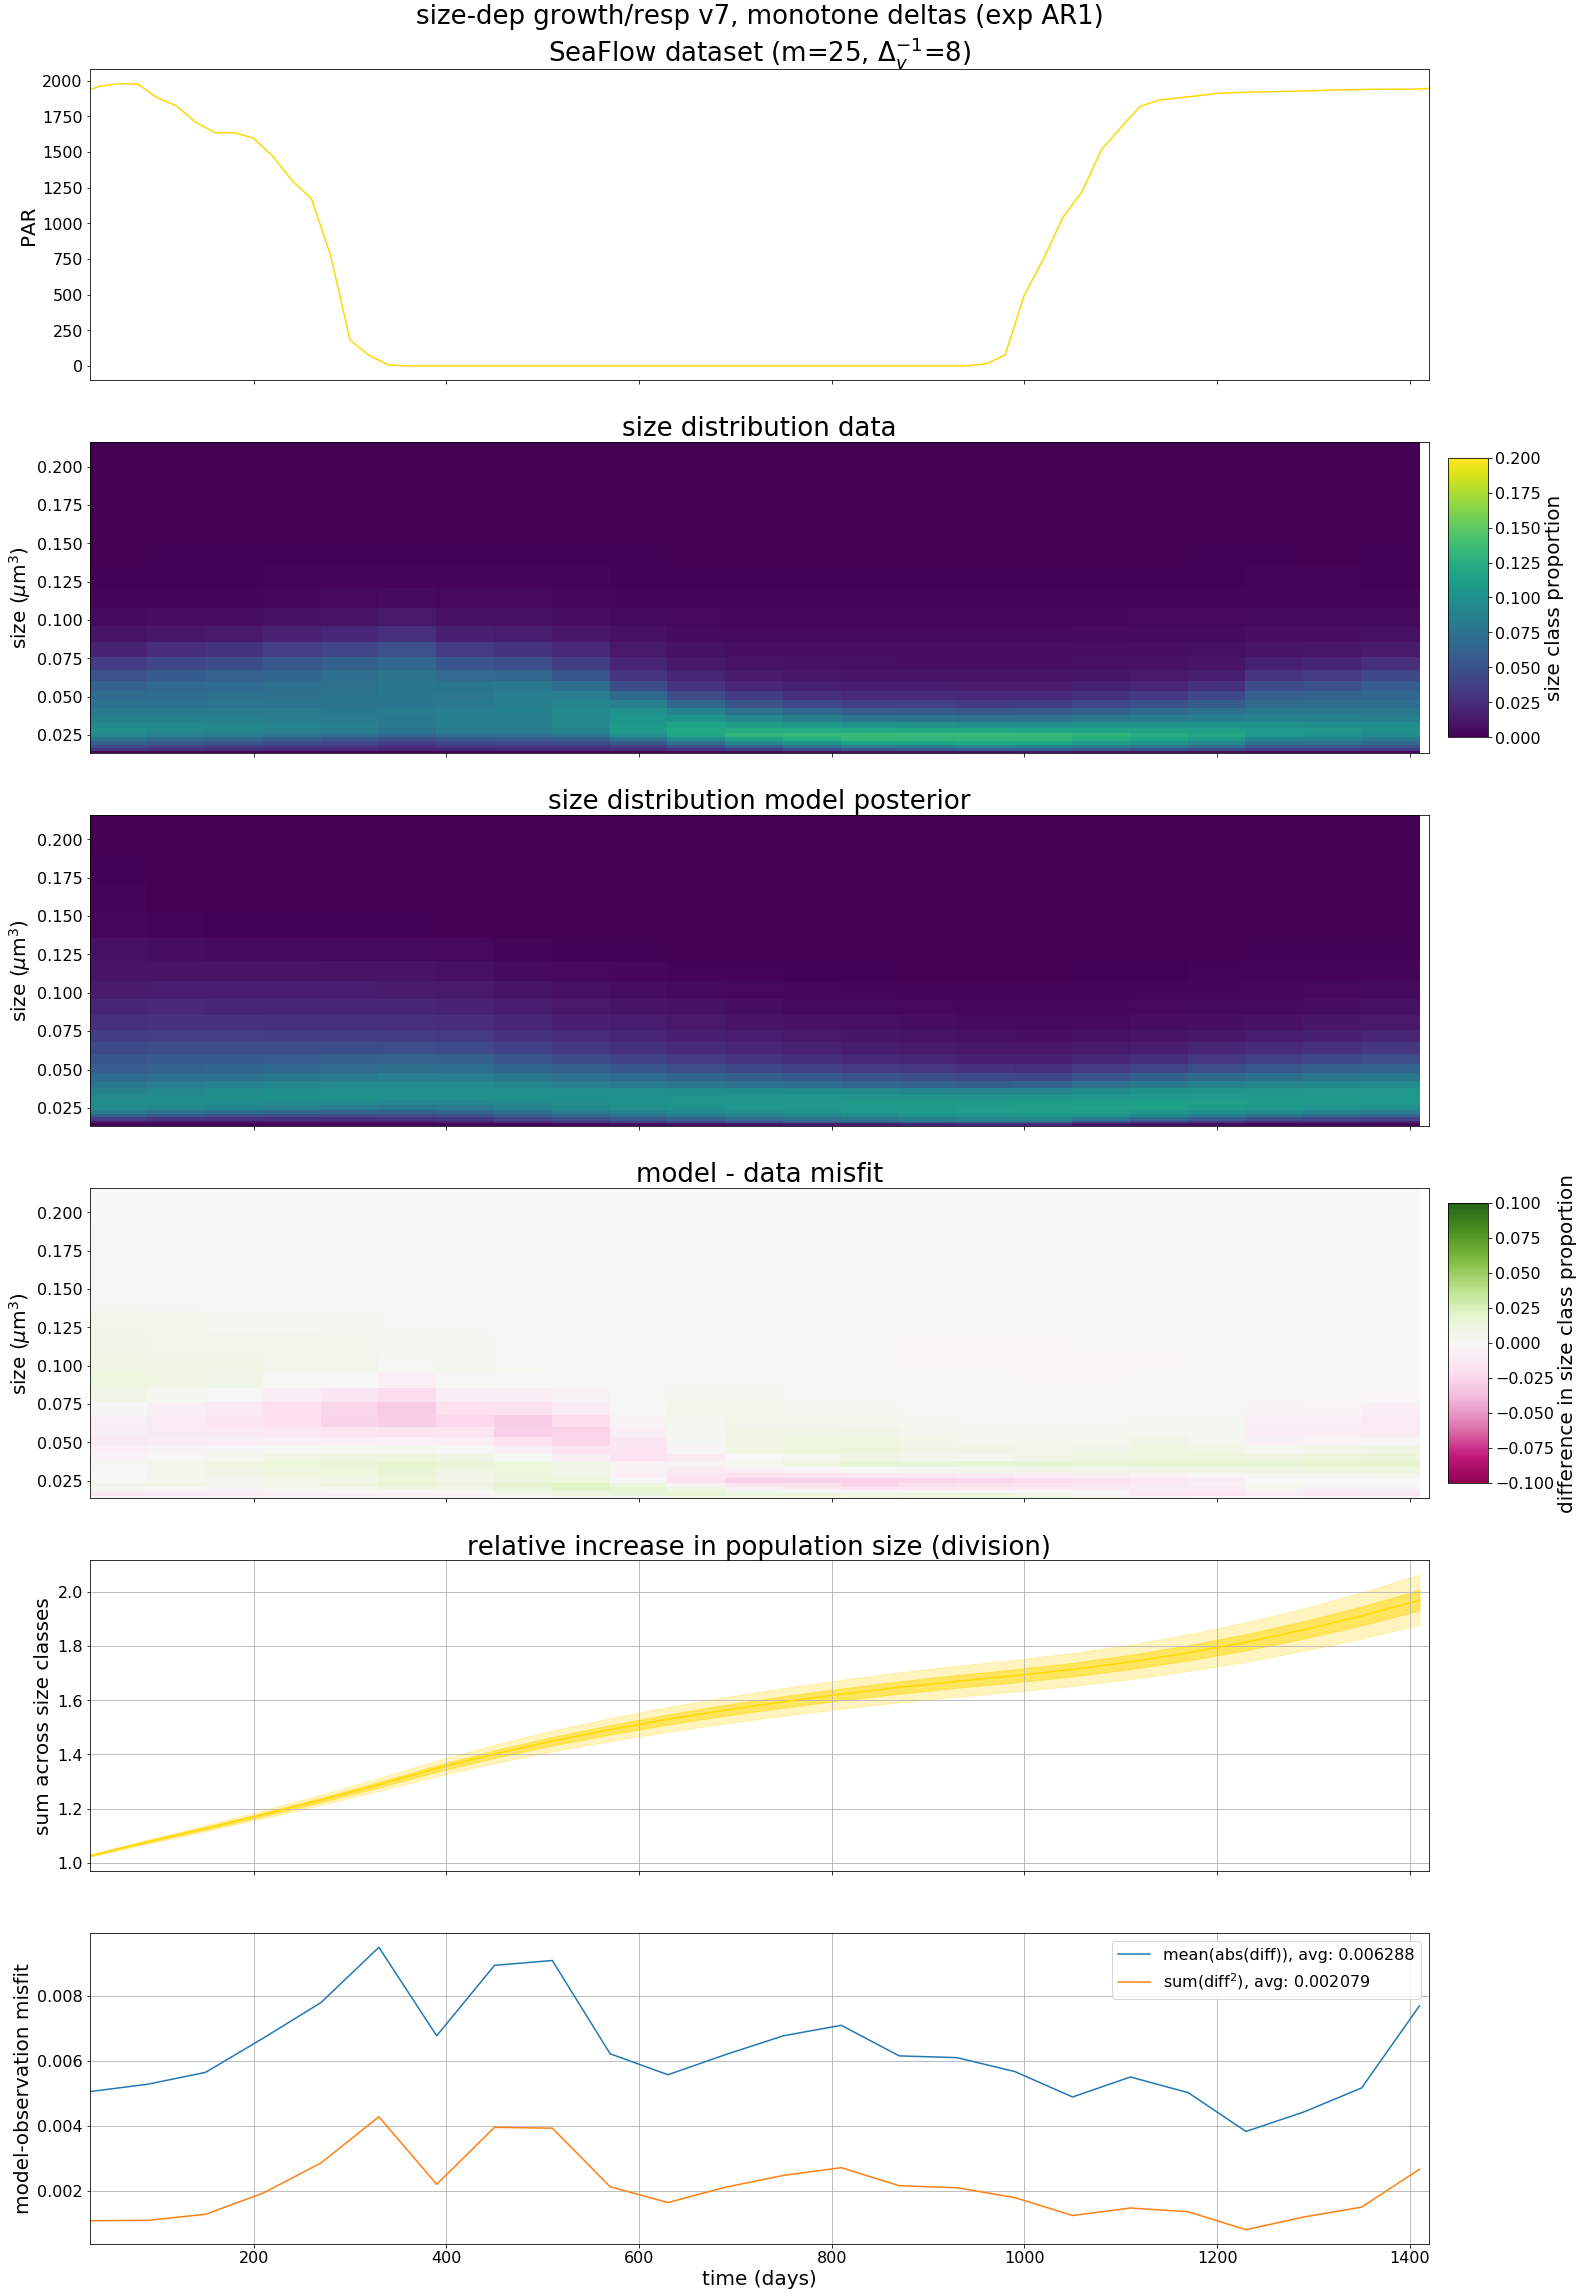

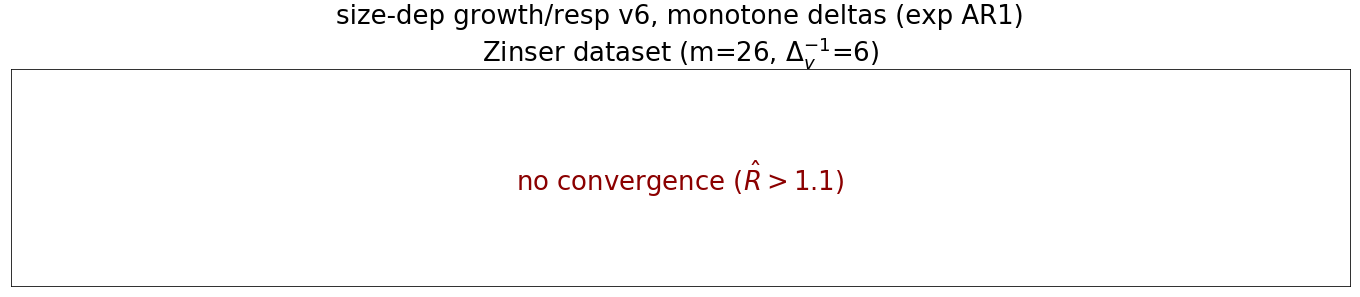

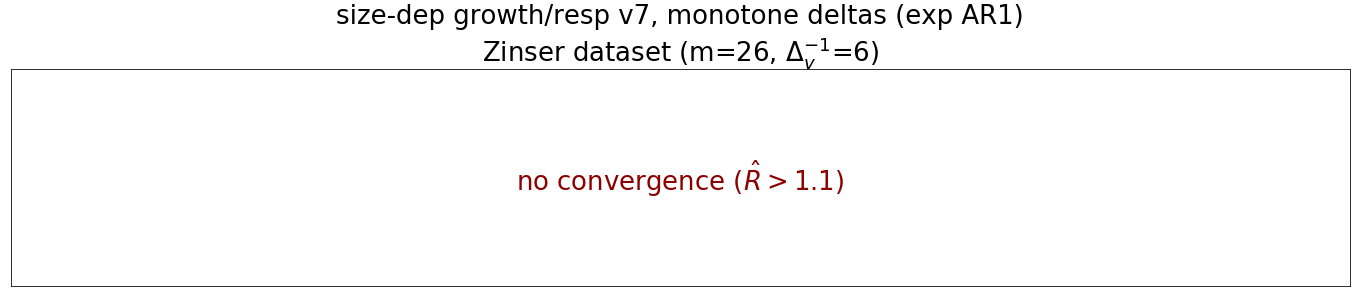

In [58]:
import pandas

data_fig2a = pandas.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for k in data:
    for name,mcmc in mcmcs.items():
        t = data[k]['dt']*np.arange(data[k]['nt'])
        v_ext = data[k]['v_min'] * 2**(np.arange(data[k]['m']+1)*delta_v) 
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]
        
        res = {'model':np.mean(mcmc[k]['mod_obspos'], axis=0), 'obs':data[k]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        if maxrhats[name][k] > 1.1:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.set_title(desc_model[name] + '\n' + desc[k])
            ax.set(xticks=[], yticks=[])
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
            continue
        
        fig,axs = plt.subplots(6,1,sharex=True,figsize=(24,40))
        axs[0].set_title(desc_model[name] + '\n' + desc[k])

        ax = axs[0]
        ax.plot(t, data[k]['E'], color='gold')
        ax.set(xlim=(data[k]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[k]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution data')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution model posterior')
        pc = ax.pcolormesh(data[k]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[k]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)', title='model - data misfit')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')
        
        qq = np.percentile(np.sum(mcmc[k]['mod_obspos'], axis=1), axis=0, q=(5,25,50,75,95))
    
        ax = axs[4]
        ax.fill_between(data[k]['t_obs'], qq[0,:], qq[-1,:], alpha=0.25, color='gold')
        ax.fill_between(data[k]['t_obs'], qq[1,:], qq[-2,:], alpha=0.5, color='gold')
        ax.plot(data[k]['t_obs'], qq[2,:], color='gold')
        if 'zinser' in k:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.grid(True)
        ax.set(ylabel='sum across size classes', title='relative increase in population size (division)')

        ax = axs[5]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[k]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[k]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (days)', ylabel='model-observation misfit')
        ax.grid(True)
        ax.legend()